## 06-02 Dropout

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

### 1.Dropout Regularization

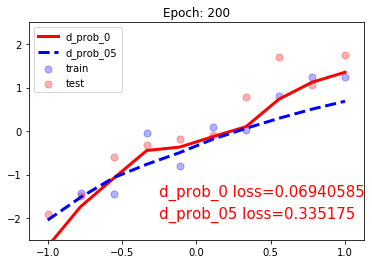

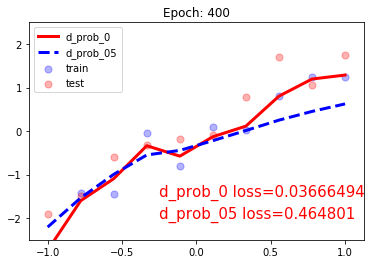

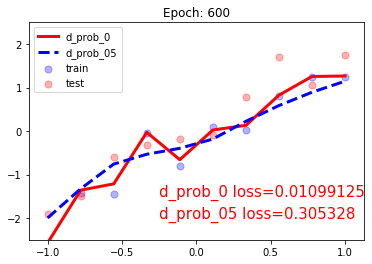

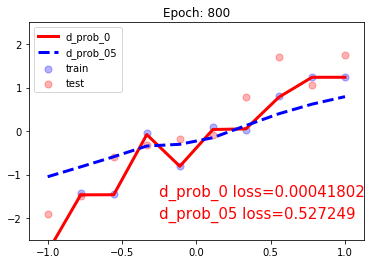

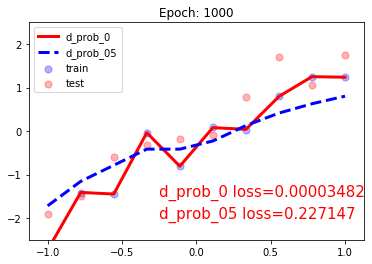

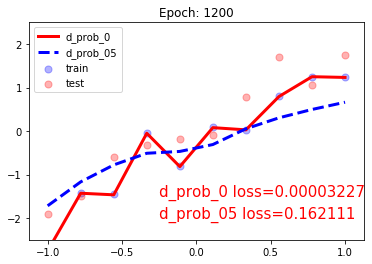

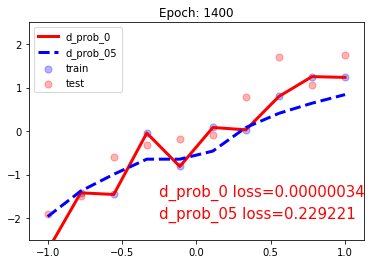

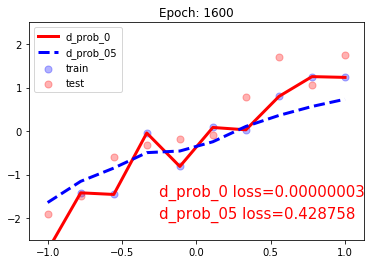

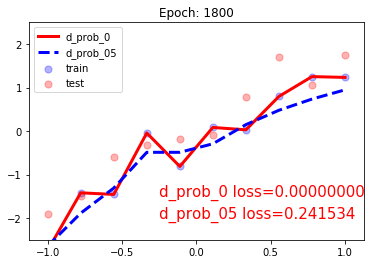

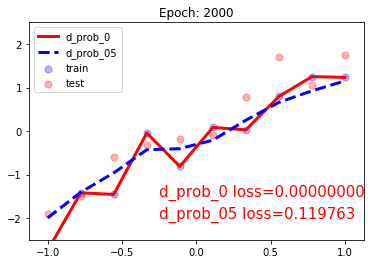

In [6]:
def generate_data(num_data=10, x_range=(-1, 1)):
    train_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    train_y = 1.5 * train_x + torch.normal(0, 0.5, size=train_x.size())
    test_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    test_y = 1.5 * test_x + torch.normal(0, 0.3, size=test_x.size())
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = generate_data()

class MLP(nn.Module):
    def __init__(self, num_hidden, d_prob=0.5):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(inplace=True),
            
            nn.Dropout(d_prob),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(inplace=True),
            
            nn.Dropout(d_prob),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(inplace=True),
            
            nn.Dropout(d_prob),
            nn.Linear(num_hidden, 1)
        )
    def forward(self, x):
        return self.linears(x)

net_prob_0 = MLP(num_hidden=256, d_prob=0.)
net_prob_05 = MLP(num_hidden=256, d_prob=0.5)

optim_normal = torch.optim.SGD(net_prob_0.parameters(), lr=1e-2, momentum=0.9)
optim_regular = torch.optim.SGD(net_prob_05.parameters(), lr=1e-2, momentum=0.9)

loss_func = torch.nn.MSELoss()

writer = SummaryWriter(comment='_dropout', filename_suffix="_dropout")
for epoch in range(2000):

    pred_normal, pred_dropout = net_prob_0(train_x), net_prob_05(train_x)
    loss_normal, loss_dropout = loss_func(pred_normal, train_y), loss_func(pred_dropout, train_y)

    optim_normal.zero_grad()
    optim_regular.zero_grad()

    loss_normal.backward()
    loss_dropout.backward()

    optim_normal.step()
    optim_regular.step()

    if (epoch + 1) % 200 == 0:

        net_prob_0.eval()
        net_prob_05.eval()

        for name, layer in net_prob_0.named_parameters():
            writer.add_histogram(name + '_grad_normal', layer.grad, epoch)
            writer.add_histogram(name + '_data_normal', layer, epoch)

        for name, layer in net_prob_05.named_parameters():
            writer.add_histogram(name + '_grad_regularization', layer.grad, epoch)
            writer.add_histogram(name + '_data_regularization', layer, epoch)

        test_pred_prob_0, test_pred_prob_05 = net_prob_0(test_x), net_prob_05(test_x)

        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_prob_0.data.numpy(), 'r-', lw=3, label='d_prob_0')
        plt.plot(test_x.data.numpy(), test_pred_prob_05.data.numpy(), 'b--', lw=3, label='d_prob_05')
        plt.text(-0.25, -1.5, 'd_prob_0 loss={:.8f}'.format(loss_normal.item()), fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'd_prob_05 loss={:.6f}'.format(loss_dropout.item()), fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch+1))
        plt.show()
        plt.close()

        net_prob_0.train()
        net_prob_05.train()


### 2.Dropout Layer

In [13]:
class Net(nn.Module):
    def __init__(self, num_hidden, d_prob=0.5):
        super(Net, self).__init__()

        self.linears = nn.Sequential(
            nn.Dropout(d_prob),
            nn.Linear(num_hidden, 1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.linears(x)

x = torch.ones((10000, ), dtype=torch.float32)
net = Net(10000, d_prob=0.5)
net.linears[1].weight.detach().fill_(1.)

net.train()
y = net(x)
print('Train Mode:', y)

net.eval()
y = net(x)
print('Eval Mode:', y)

Train Mode: tensor([10068.], grad_fn=<ReluBackward1>)
Eval Mode: tensor([10000.], grad_fn=<ReluBackward1>)
